# <center>Graph Colouring with Quantum Annealing</center>

In this notebook we have solved a graph colouring problem on a randomly generated graph of `n` nodes with randomly generated connectivity between nodes.

Different solvers, inlcuding RacingBranches and DWaveSampler were used and it was concluded that ```QBSolv``` performs best.

In [2]:
from dwave.system import DWaveSampler, EmbeddingComposite
from neal import SimulatedAnnealingSampler
import numpy as np
import dimod
import networkx as nx
import matplotlib.pyplot as plt
import hybrid
from dwave_qbsolv import QBSolv
import matplotlib.colors as mcolors
from geopy import geocoders  
%matplotlib inline         

/home/fazal/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


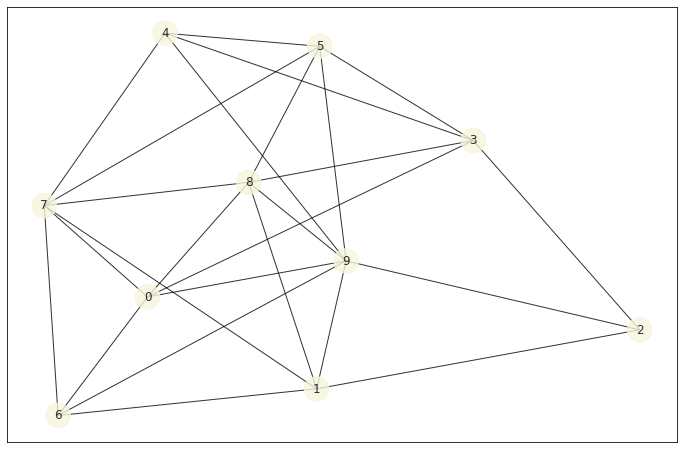

Sample(sample={'0_0': 0, '0_1': 0, '0_2': 0, '0_3': 0, '0_4': 1, '0_5': 0, '0_6': 0, '0_7': 0, '0_8': 0, '1_0': 0, '1_1': 0, '1_2': 0, '1_3': 0, '1_4': 1, '1_5': 0, '1_6': 0, '1_7': 0, '1_8': 0, '2_0': 0, '2_1': 0, '2_2': 0, '2_3': 0, '2_4': 0, '2_5': 0, '2_6': 1, '2_7': 0, '2_8': 0, '3_0': 0, '3_1': 0, '3_2': 1, '3_3': 0, '3_4': 0, '3_5': 0, '3_6': 0, '3_7': 0, '3_8': 0, '4_0': 0, '4_1': 0, '4_2': 0, '4_3': 0, '4_4': 1, '4_5': 0, '4_6': 0, '4_7': 0, '4_8': 0, '5_0': 0, '5_1': 0, '5_2': 0, '5_3': 0, '5_4': 0, '5_5': 0, '5_6': 0, '5_7': 1, '5_8': 0, '6_0': 0, '6_1': 0, '6_2': 0, '6_3': 0, '6_4': 0, '6_5': 0, '6_6': 0, '6_7': 1, '6_8': 0, '7_0': 1, '7_1': 0, '7_2': 0, '7_3': 0, '7_4': 0, '7_5': 0, '7_6': 0, '7_7': 0, '7_8': 0, '8_0': 0, '8_1': 1, '8_2': 0, '8_3': 0, '8_4': 0, '8_5': 0, '8_6': 0, '8_7': 0, '8_8': 0, '9_0': 0, '9_1': 0, '9_2': 0, '9_3': 1, '9_4': 0, '9_5': 0, '9_6': 0, '9_7': 0, '9_8': 0}, energy=-100.0, num_occurrences=1)


/home/fazal/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


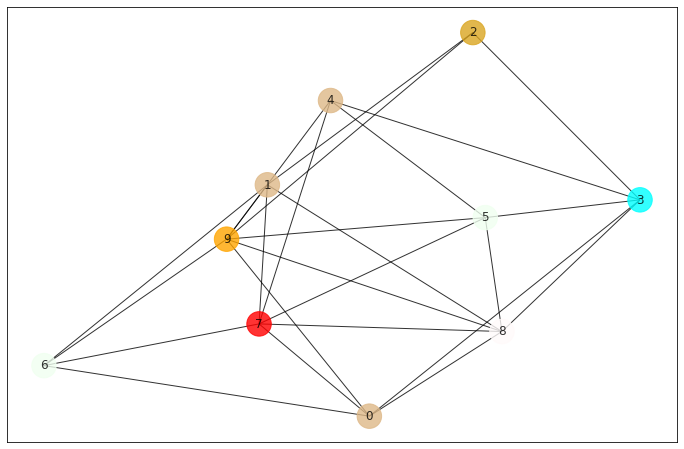

In [3]:
#---------------------------------------------------------------
#Change this value to change the number of nodes
n_nodes = 10
n_colors = 9
#---------------------------------------------------------------

def plot_graph(G, colors = ['beige']*n_nodes):
    '''
    Parameters:    G:        network.Graph()
                   colors:   a list of colors for coloring the nodes
    '''
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.show()
    
def generate_random_graph(n, p = 0.6):
    '''
    Parameters:    n:        number of nodes
                   p:        probability of nodes being connected
                   
    Return:        nx.Graph()
    '''
    return(nx.gnp_random_graph(n, p))

def graph_to_adjacency(G):
    '''
    Parameters:    G:        network.Graph()
    
    Return:        Adjacency matrix (2D-list)
    '''
    mat = nx.adjacency_matrix(G).todense()
    return(tuple(mat.tolist()))

def graphcolour_QUBO(G, ncolours, constr=10):
    #This function returns the appropriate QUBO dictionary for given parameters
    Q = {}
    for i in range(0,len(G)):
        for j in range(0,ncolours):
            for k in range(0,len(G)):
                for l in range(0,ncolours):
                    Q[(str(i) + "_" + str(j), str(k) + "_" + str(l))] = 0
            
    #Objective, we dont want adjacent vertices to share the colour
    for i in range(0,len(G)):
        for j in range(0,ncolours):
            for k in range(i+1,len(G)):
                if G[i][k] == 1:
                    Q[(str(i) + "_" + str(j), str(k) + "_" + str(j))] = 1
    #Constraint: Every vertex is painted of exactly one colour
    for i in range(0,len(G)):
        for j in range(0,ncolours):
            for k in range(0,ncolours):
                if j == k:
                    Q[(str(i) + "_" + str(j), str(i) + "_" + str(j))] = Q[(str(i) + "_" + str(j), str(i) + "_" + str(j))] - constr
                else:
                    Q[(str(i) + "_" + str(j), str(i) + "_" + str(k))] = Q[(str(i) + "_" + str(j), str(i) + "_" + str(k))] + constr
    return (Q)

def get_colors(G, final_state):
    #This function returns the colors of each node when a solution state is passed as parameter
    colors = ['0'] * len(list(G.nodes))
    c_map = list(set(list(mcolors.CSS4_COLORS.keys())))
    c_map = c_map[0:n_colors]

    for k, v in final_state.first[0].items():
        if v == 1:
            if len(k) == 3:
                node = int(k[0])
                color = int(k[-1])
                colors[node] = c_map[color]
            if len(k) == 4:
                node = int(k[0:2])
                color = int(k[-1])
                colors[node] = c_map[color]
    
    return(colors)

def verify_results(G, colors):
    #Checks if the results are correct and no two adjacent nodes have the same color
    connections = list(G.edges)
    for connection in connections:
        node_1 = connection[0]
        node_2 = connection[1]
    
        if colors[node_1] == colors[node_2]:
            print("Test Failed at", connection)
'''
#Not required
def get_j(Q):
    j = {}
    for i in list(Q.keys()):
        if i[0] == i[1]:
            j[i[0]] = Q[(i[0], i[1])]
    return(j)

def get_H(Q):
    H = {}
    for i in list(Q.keys()):
        if i[0] != i[1]:
            H[(i[0], i[1])] = Q[(i[0], i[1])]
    return(H)
'''

#Generate random graph
G = generate_random_graph(n_nodes)

#Plot Graph
plot_graph(G)

#Get adjacency matrix
adj = graph_to_adjacency(G)

#Get Qubomax(dict(G.degree()).items(), key = lambda x: x[1])[1]
Q = graphcolour_QUBO(adj, n_colors)

'''
#Get linear and quadratic terms
j, H = get_j(Q), get_H(Q)
bqm = dimod.BinaryQuadraticModel(j, H, 0, dimod.BINARY)

# Define the workflow
iteration = hybrid.RacingBranches(
    hybrid.Identity(),
    hybrid.InterruptableTabuSampler(),
    hybrid.EnergyImpactDecomposer(size=2)
    | hybrid.QPUSubproblemAutoEmbeddingSampler()
    | hybrid.SplatComposer()
) | hybrid.ArgMin()
workflow = hybrid.LoopUntilNoImprovement(iteration, convergence=3)

# Solve the problem
init_state = hybrid.State.from_problem(bqm)
final_state = workflow.run(init_state).result()

# Print results
print("Solution: sample={.samples.first}".format(final_state))
'''
#QBSolv reaches a solution much faster than RacingBranches, SimulatedAnnealing and DWaveSampler

sampler = QBSolv()
final_state = sampler.sample_qubo(Q, num_reads = 1000)
print(final_state.first)

c = get_colors(G, final_state)

plot_graph(G, c)
verify_results(G, c) #This function will print a faliure message if the solution is incorrect.

In [17]:
locs = [
    "Wausaw, WI",
    "Chicago, IL",
    "Detroit, MI",
    "Indianapolis, IN",
    "Columbus, OH",
    
    "Chapman, PA",
    "Kilington, VT",
    "Corning, NY",
    "New York, NY",
    
    "Charlotte, NC",
    "Roanoke, VA",
    
    "Little Rock, AR",
    "Conway, AR",
    "Baton Rouge, LA",
    
    "Jackson, MS",
    "Birmingham, AL",
    "Louisville, KY",
    "Nashville, TN",
    
    "Atlanta, GA",
    "Acala, FL",
    "Miami, FL"    
]

def convert_to_coordinates(locs):
    coord_lst = {}
    gn = geocoders.ArcGIS()
    for idx, loc in enumerate(locs):
        loc_obj = gn.geocode(loc)
        coords = (loc_obj.latitude, loc_obj.longitude)
        coord_lst[idx] = coords
    return(coord_lst)

def get_loc_graph(locs):
    coord_lst = convert_to_coordinates(locs)
    
    G = nx.Graph()
    for key, val in coord_lst.items():
        G.add_node(key, pos=val)
    
    blocks = [[0,5], [5,9], [9,11], [11,14], [14,18], [18,21]]

    for block in blocks:
        for i in range(block[0],block[1]):
            for j in range(i+1, block[1]):
                G.add_edge(i, j)
                
    return(G)

def solve_map():
    G = get_loc_graph(locs)
    
    plt.figure(figsize=(12,12))
    nx.draw_networkx(G, node_size=600, pos=nx.get_node_attributes(G, 'pos'))
    plt.show()
    
    #Get adjacency matrix
    adj = graph_to_adjacency(G)

    #Get Qubomax(dict(G.degree()).items(), key = lambda x: x[1])[1]
    Q = graphcolour_QUBO(adj, 5)
    
    sampler = QBSolv()
    final_state = sampler.sample_qubo(Q, num_reads = 1000)
    print(final_state.first)

    c = get_colors(G, final_state)

    plt.figure(figsize=(12,12))
    nx.draw_networkx(G, node_color=c, node_size=600, pos=nx.get_node_attributes(G, 'pos'))
    plt.show()
    

/home/fazal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/fazal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/fazal/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


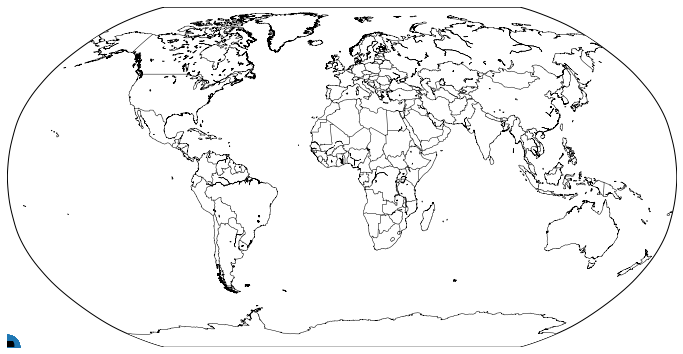

Sample(sample={'0_0': 0, '0_1': 0, '0_2': 0, '0_3': 0, '0_4': 1, '10_0': 0, '10_1': 0, '10_2': 0, '10_3': 0, '10_4': 1, '11_0': 0, '11_1': 0, '11_2': 0, '11_3': 1, '11_4': 0, '12_0': 0, '12_1': 0, '12_2': 0, '12_3': 0, '12_4': 1, '13_0': 1, '13_1': 0, '13_2': 0, '13_3': 0, '13_4': 0, '14_0': 0, '14_1': 0, '14_2': 1, '14_3': 0, '14_4': 0, '15_0': 1, '15_1': 0, '15_2': 0, '15_3': 0, '15_4': 0, '16_0': 0, '16_1': 1, '16_2': 0, '16_3': 0, '16_4': 0, '17_0': 0, '17_1': 0, '17_2': 0, '17_3': 1, '17_4': 0, '18_0': 0, '18_1': 0, '18_2': 1, '18_3': 0, '18_4': 0, '19_0': 0, '19_1': 0, '19_2': 0, '19_3': 0, '19_4': 1, '1_0': 0, '1_1': 1, '1_2': 0, '1_3': 0, '1_4': 0, '20_0': 1, '20_1': 0, '20_2': 0, '20_3': 0, '20_4': 0, '2_0': 1, '2_1': 0, '2_2': 0, '2_3': 0, '2_4': 0, '3_0': 0, '3_1': 0, '3_2': 0, '3_3': 1, '3_4': 0, '4_0': 0, '4_1': 0, '4_2': 1, '4_3': 0, '4_4': 0, '5_0': 0, '5_1': 1, '5_2': 0, '5_3': 0, '5_4': 0, '6_0': 1, '6_1': 0, '6_2': 0, '6_3': 0, '6_4': 0, '7_0': 0, '7_1': 0, '7_2': 0, 

/home/fazal/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


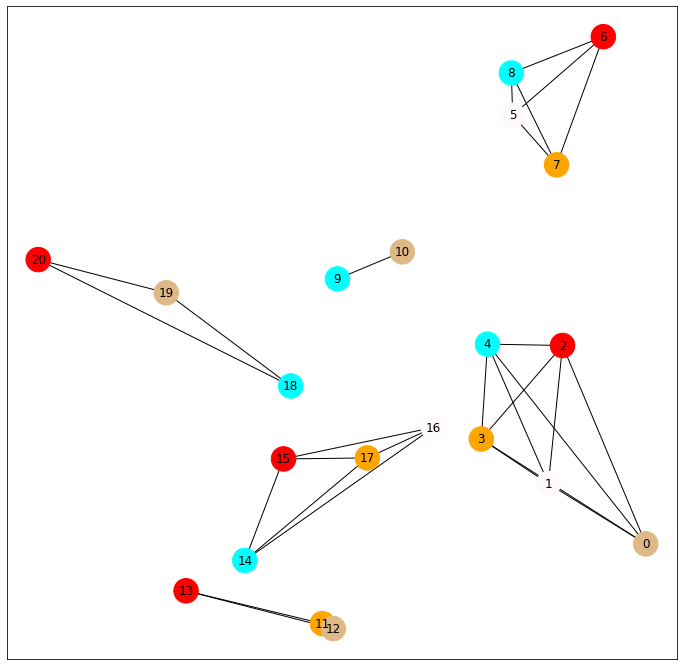

In [18]:
solve_map()

In [11]:
from mpl_toolkits.basemap import Basemap

/home/fazal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/home/fazal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


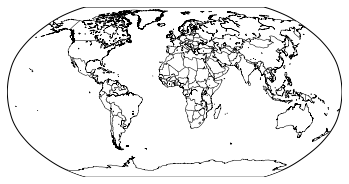

In [14]:
m = Basemap(projection='robin',lon_0=0,resolution='l')
m.drawcountries(linewidth = 0.5)
m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.5)

NetworkXError: Node 0 has no position.

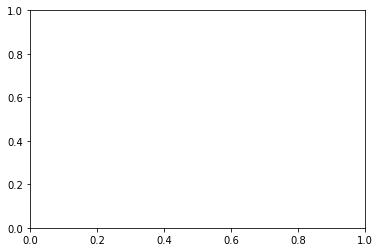

In [16]:
nx.draw_networkx_nodes(G, pos=nx.get_node_attributes(G, 'pos'))